In [13]:
# Importing libraries
using DataFrames
using LinearAlgebra
using Statistics
using Plots
using Random
using GLM
import CSV
using FreqTables
import Measures

In [14]:
# Downloading and extract the dataset
X_file = "data_kPCA_2022-2023.txt"
y_file = "labels_kPCA_2022-2023.txt"
url = "https://raw.githubusercontent.com/alexdepremia/Unsupervised-Learning-Datasets/main/"

if !isfile(X_file)
    run(`wget $(url*X_file)`)
end
if !isfile(y_file)
    run(`wget $(url*y_file)`);
end

In [15]:
# Utility function for plots

MARGIN = 4Measures.mm;

function extend_plot!()
    plot!(size = (800, 400),
    bottom_margin = MARGIN,
    left_margin = MARGIN,
    top_margin = MARGIN)
end;

In [16]:
LIMIT = false

# Loading the dataset (X, y)
X = Float32.(Matrix(DataFrame(CSV.File("data_kPCA_2022-2023.txt", delim=" ", header=false))))
y = parse.(Int8, readlines(open("labels_kPCA_2022-2023.txt")))

if typeof(LIMIT)==Int
    X = X[1:LIMIT, :]
    y = y[1:LIMIT]
end

p = size(X)[2]

# Splitting train and test sets
train_prop = 0.8
n = length(y)
n_train = Int(round(train_prop*n))

X_train = X[begin:n_train, :]
X_test = X[n_train+1:end, :]
y_train = y[begin:n_train]
y_test = y[n_train+1:end]

n_test = length(y_test);

In [17]:
# Centering and rescaling features
mean = Statistics.mean(X_train, dims=1)
std = Statistics.std(X_train, dims=1)
X = (X.-mean)./std
X_train = (X_train.-mean)./std
X_test = (X_test.-mean)./std;

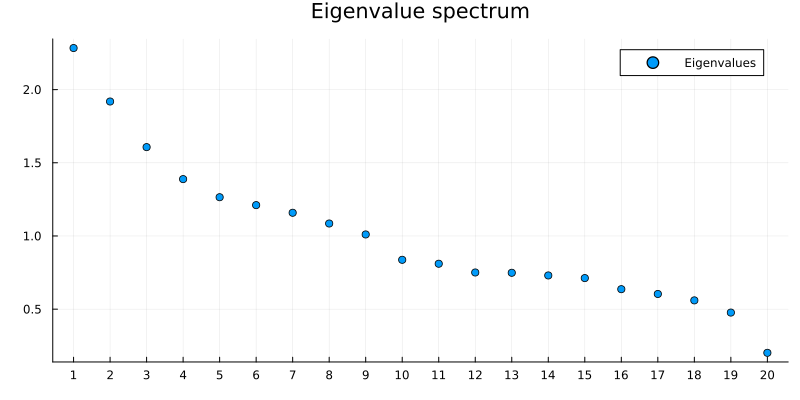

In [18]:
# Computing covariance matrix (train set)
c = (transpose(X_train)*X_train)/size(X_train)[1]

# Computing eigenvalues and eigenvectors (train set)
eig = eigen(c)
eigenvectors = eig.vectors[:, end:-1:begin]
eigenvalues = reverse(eig.values);

# Plotting the eigenvalue spectrum (train set)
plot(eigenvalues,
    seriestype=:scatter,
    label="Eigenvalues",
    xticks=1:length(eigenvalues),
    title = "Eigenvalue spectrum")
extend_plot!()


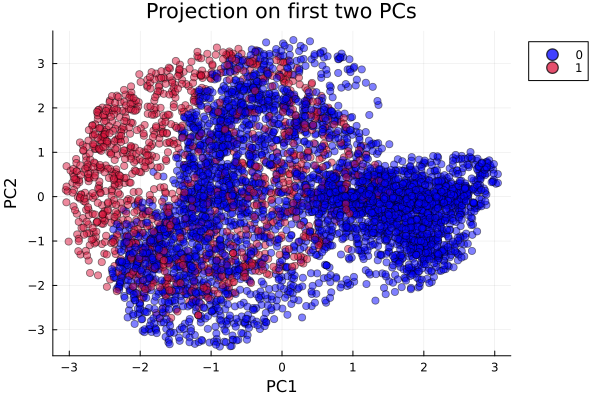

In [19]:
# Computing projection on principal components (train set)
pc_train = X_train*eigenvectors;

# Plotting data projected on first two principal components (train set)
function plot_PCs(pc, labels)
    distinguishable_colors = ("blue", "crimson")

    classes = sort(unique(labels))
    color_dict = Dict(c => distinguishable_colors[i] for (i,c) in enumerate(classes))
    colors = map(class -> color_dict[class], labels)

    pc_plot = plot(
        pc[:, 1],
        pc[:, 2],
        color = colors,
        alpha=.5,
        xlabel="PC1",
        ylabel="PC2",
        seriestype=:scatter,
        title = "Projection on first two PCs",
        label=nothing
    )

    # The following is a trick done in order to show the legend
    for class in classes
        indexes = (1:length(labels))[labels .== class]

        plot!(
            pc[indexes[1:2], 1],
            pc[indexes[1:2], 2],
            color=color_dict[class],
            label = string(class),
            seriestype=:scatter,
            alpha=0.75,
            legend = :outertopright)
    end

    return pc_plot

end

plot_PCs(pc_train, y_train)

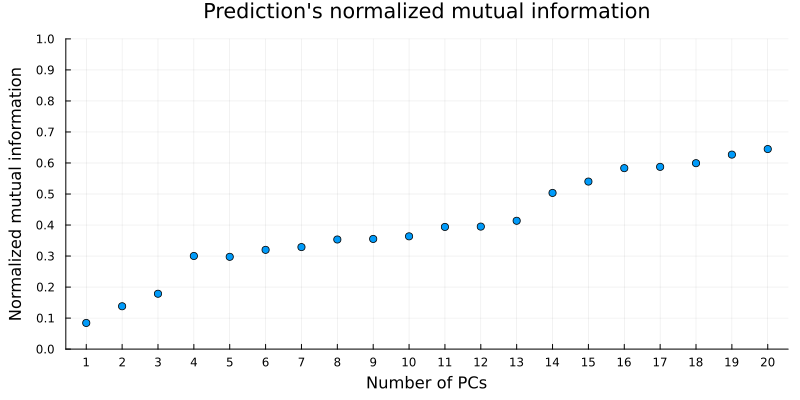

In [20]:
# Logistic regression
function I(a, b)
    p = freqtable(DataFrame(a = a, b = b), :a, :b) / length(a)
    n_classes_a = length(unique(a))
    n_classes_b = length(unique(b))
    sum([p[i,j]>0. ? p[i,j]*log(p[i,j]/(sum(p[i,:])*sum(p[:,j]))) : 0 for i=1:n_classes_a, j=1:n_classes_b])
end

function NMI(a, b)
    p = freqtable(DataFrame(a = a, b = b), :a, :b) / length(a)
    n_classes_a = length(unique(a))
    n_classes_b = length(unique(b))
    mi = sum([p[i,j]>0. ? p[i,j]*log(p[i,j]/(sum(p[i,:])*sum(p[:,j]))) : 0 for i=1:n_classes_a, j=1:n_classes_b])
    
    p_a = sum(p[1, :])
    p_b = sum(p[:, 1])
    h_a = p_a > 0 ? -p_a * log(p_a) : 0.
    h_b = p_b > 0 ? -p_b * log(p_b) : 0.

    return 2*mi/(p_a + p_b)
end

function accuracy(a, b)
    p = freqtable(DataFrame(a = a, b = b), :a, :b) / length(a)
    n_classes_a = length(unique(a))
    n_classes_b = length(unique(b))
    sum([p[i, i] for i=1:n_classes_b])
end

function logistic_regression_experiment(pc_train, pc_test, y_train, y_test, components_range)
    mi = zeros(components_range)
    #acc = zeros(pc_limit)

    for i in 1:components_range
        x_train = hcat(ones(size(pc_train)[1]), pc_train[:,begin:i]) # I have to add the bias manually...
        x_test = hcat(ones(size(pc_test)[1]), pc_test[:,begin:i]) # I have to add the bias manually...
        model = glm(x_train, y_train, Bernoulli())
        y_predicted = predict(model, x_test).>0.5
        mi[i] = NMI(y_test, y_predicted)
        #acc[i] = accuracy(y_test, y_predicted)
    end

    plot(mi,
        seriestype=:scatter,
        label=nothing,
        xticks=1:length(mi),
        ylims=(0.,1.),
        xlabel = "Number of PCs",
        ylabel = "Normalized mutual information",
        yticks = 0:0.1:1,
        title = "Prediction's normalized mutual information")
    extend_plot!()
end

# Getting test set projection on PCs
pc_test = X_test*eigenvectors;
logistic_regression_experiment(pc_train, pc_test, y_train, y_test, 20)

## Kernel PCA

In [21]:
# Computing the Kernel matrix

# Computing l2 Kernel matrix
l2_K(m) = (sum((reshape(m, (1, size(m)[1], size(m)[2])) .- reshape(m, (size(m)[1], 1, size(m)[2]))).^2f0, dims=3))[:,:,1]
l2_K_matrix = l2_K(X);

# Computing Gaussian Kernel matrix
Gaussian_K(l2_K_matrix, width) = exp.(-0.5f0 .* l2_K_matrix ./ (width^2f0))
width = 1.5f0
K = Gaussian_K(l2_K_matrix, width);

# Get Gram matrix by double Centering
function double_centering(M)
    n = Float32(size(M)[1])
    return 0.5f0*(M .-sum(M, dims=1)./n .-sum(M, dims=2)./n .+ sum(M)./(n^2f0))
end

G = double_centering(K);

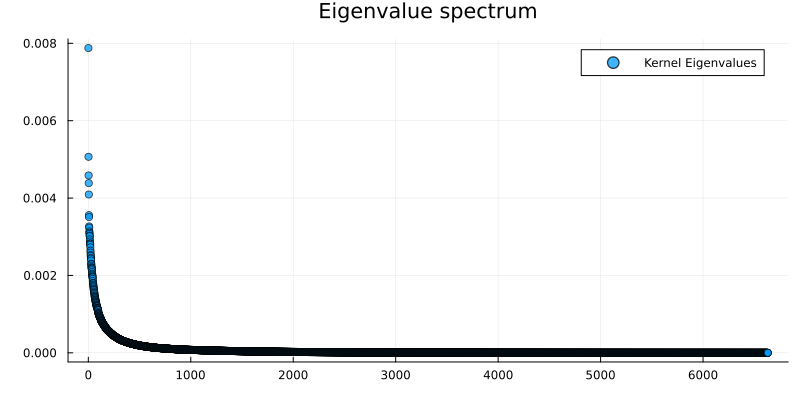

In [22]:
# Computing eigenvalues and eigenvectors

kernel_eig = eigen(Symmetric(G/size(G)[1]))
kernel_eigenvectors = kernel_eig.vectors[:, end:-1:begin]
kernel_eigenvalues = reverse(kernel_eig.values);

# Plotting the eigenvalue spectrum
plot(kernel_eigenvalues,
    seriestype=:scatter,
    label="Kernel Eigenvalues",
    alpha=0.75,
    title = "Eigenvalue spectrum")
extend_plot!()

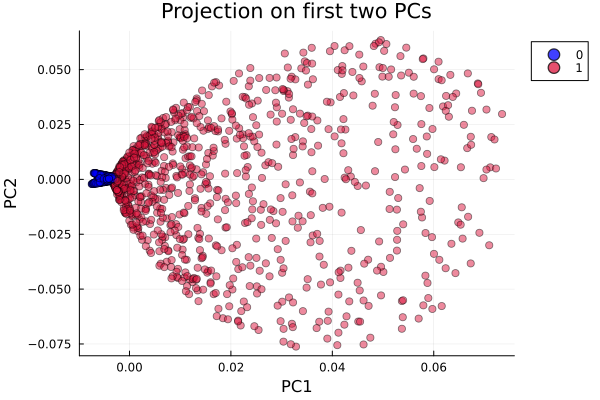

In [23]:
# Computing projection on principal components (train set)
kernel_pc_train = kernel_eigenvectors[begin:n_train, :];

# Plotting train data projected on first two principal components (train set)
plot_PCs(kernel_pc_train, y_train)

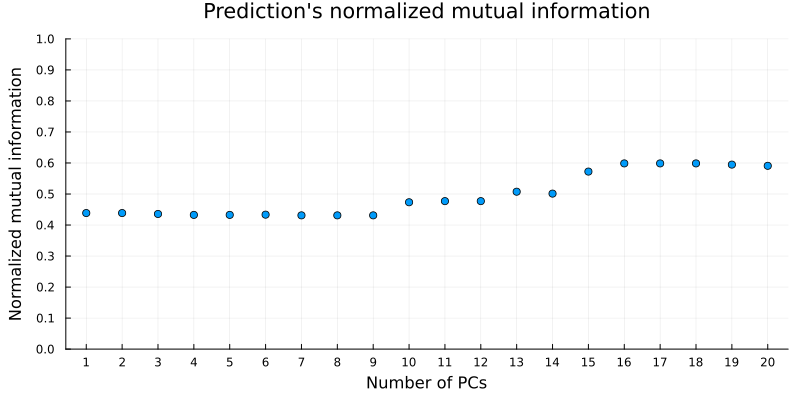

In [24]:
# Logistic Regression

# Computing projection on principal components (test set)
kernel_pc_test = kernel_eigenvectors[n_train+1:end, :];

logistic_regression_experiment(kernel_pc_train, kernel_pc_test, y_train, y_test, 20)